<a href="https://colab.research.google.com/github/Wqcapstone1234/Enhancing-Basic-VIX-Strategy/blob/main/MScFE_690_Capstone_Code_Group_9171.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
#Install Libraries
!pip install ta
!pip install hmmlearn

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=b7043474ac6ff8c7176185052995422fc53b39bb0ba820ce38b387ae8ae91a78
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 2.6 MB/s eta 0:00:00


In [3]:
#Import Libraries
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import time

from ta.momentum import RSIIndicator
from statsmodels.tsa.stattools import ccf
from hmmlearn import hmm
import statsmodels.api as sm

# Data Collection

In [4]:
start_date = datetime.date(2020, 1, 1)
end_date   = datetime.date(2024, 12, 31)
VOO        = yf.download(['VOO'], start_date, end_date)
VIX        = yf.download(['^VIX'], start_date, end_date)
VOO_close  = VOO[['Close']]
VIX_close  = VIX[['Close']]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Exploratory Data Analysis

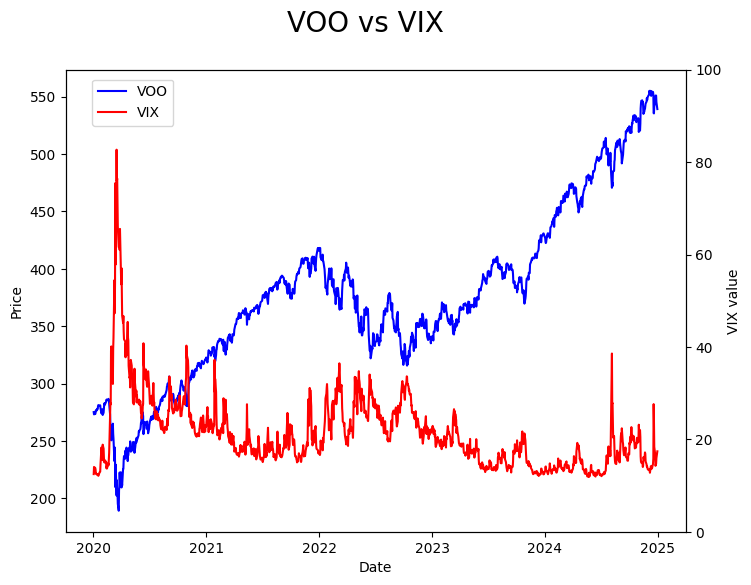

In [5]:
df = pd.concat([VOO['Close'], VIX['Close']],axis=1)

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax2.set_ylim(0, 100)

# Plot lines with labels
ax1.plot(df.index, df['VOO'], color='b', label='VOO')
ax2.plot(df.index, df['^VIX'], color='r', label='VIX')

ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax2.set_ylabel("VIX value")

fig.suptitle("VOO vs VIX", fontsize=20)

# Get legend handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create a single legend for the figure
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.15, 0.875))

# Display the plot
plt.show()


# Regime Analysis on the VIX level

<ipython-input-6-d6c75a8cbeb8>:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


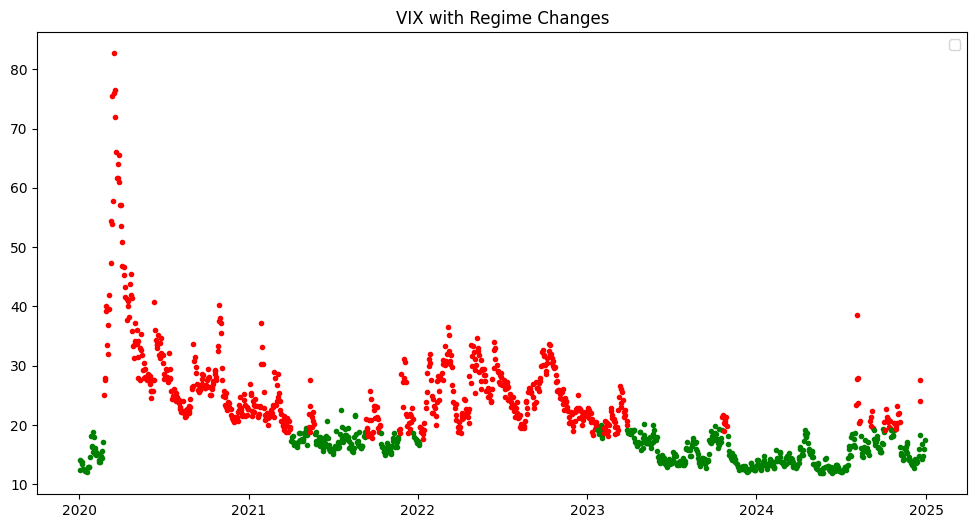

Mean VIX level for Regime 0: 12.78499984741211
Mean VIX level for Regime 1: 33.52000045776367


In [6]:
vix_values = VIX_close['Close'].values  # Extract the values as a NumPy array

# Use the NumPy array for digitization
vix_discretized = np.digitize(vix_values, bins=np.linspace(vix_values.min(), vix_values.max(), 20))


# Reshape the data for HMM (required by the library)
vix_discretized = vix_discretized.reshape(-1, 1)

# Initialize and train the HMM model
model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=10000)  # Adjust parameters as needed
model.fit(vix_discretized)


# Predict the most likely hidden states
hidden_states = model.predict(vix_discretized)

# Visualize regime changes (Optional)
plt.figure(figsize=(12, 6))

# Create a color map for the regimes
colors = ['green', 'red']  # Adjust colors as needed

for i, state in enumerate(hidden_states):
    plt.plot(VIX_close.index[i], VIX_close['Close'].iloc[i], color=colors[state], marker='o', markersize=3)

plt.title("VIX with Regime Changes")
plt.legend()
plt.show()

import numpy as np
# Calculate the mean VIX level for each regime
regime_0_vix_mean = np.percentile(VIX_close['Close'][hidden_states == 0],10)
regime_1_vix_mean = np.percentile(VIX_close['Close'][hidden_states == 1],90)

print(f"Mean VIX level for Regime 0: {regime_0_vix_mean}")
print(f"Mean VIX level for Regime 1: {regime_1_vix_mean}")


In [7]:
df['VOO pct change'] = df['VOO'].pct_change()
df['VIX pct change'] = df['^VIX'].pct_change()
df['VOO pct change sd'] = df['VOO'].pct_change().rolling(10).std()*(252**0.5)
df['VIX pct change sd'] = df['^VIX'].pct_change().rolling(10).std()*(252**0.5)
df = df.dropna()

<ipython-input-28-cff1881a5a6d>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


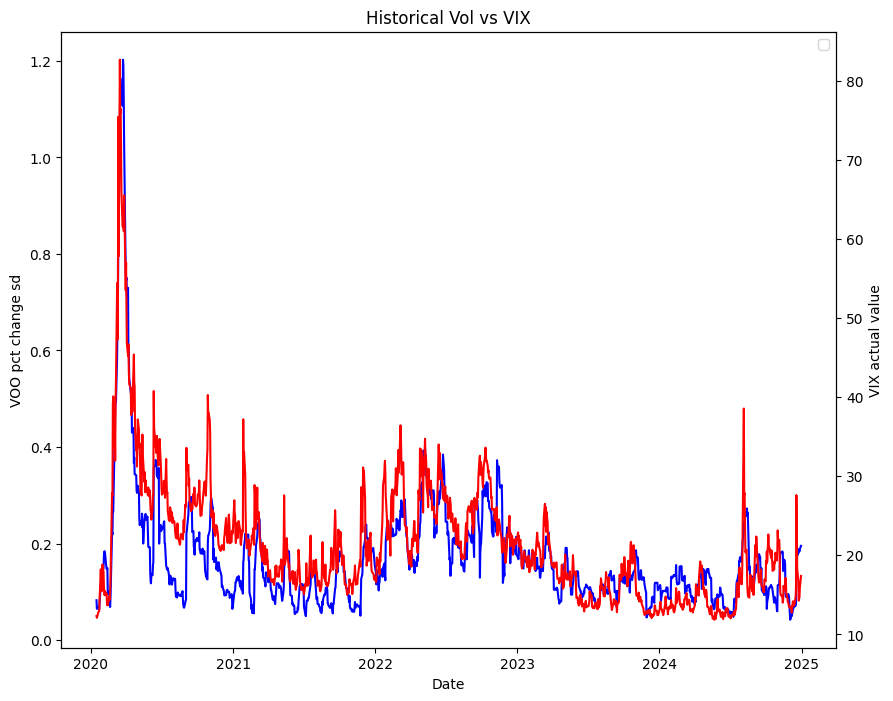

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()
ax1.plot(df.index,df['VOO pct change sd'],color ='b')
ax2.plot(df.index, df['^VIX'],color = 'r')


ax1.set_xlabel("Date")
ax1.set_ylabel("VOO pct change sd")
ax2.set_ylabel("VIX actual value")



plt.title("Historical Vol vs VIX")

#fig.suptitle("VOO pct change sd vs VIX actual value", fontsize=12)
plt.show()

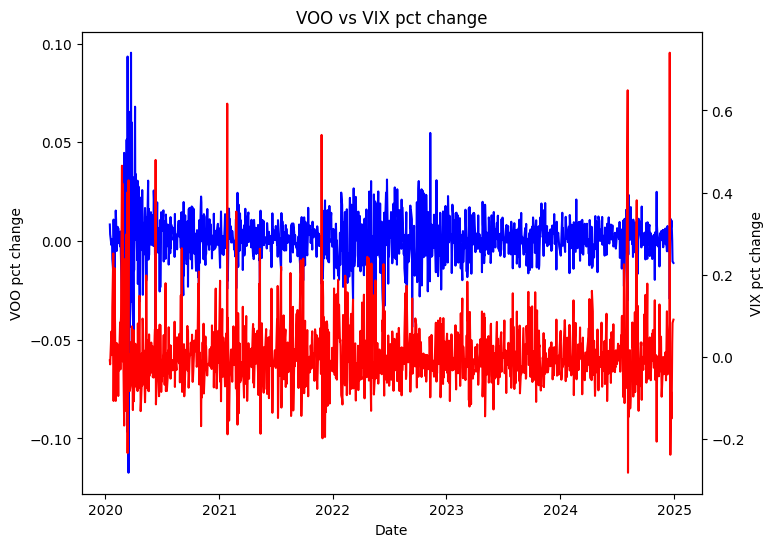

In [8]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax1.plot(df.index,df['VOO pct change'],color ='b')
ax2.plot(df.index, df['VIX pct change'],color = 'r')


ax1.set_xlabel("Date")
ax1.set_ylabel("VOO pct change")
ax2.set_ylabel("VIX pct change")

plt.title("VOO vs VIX pct change")
plt.show()

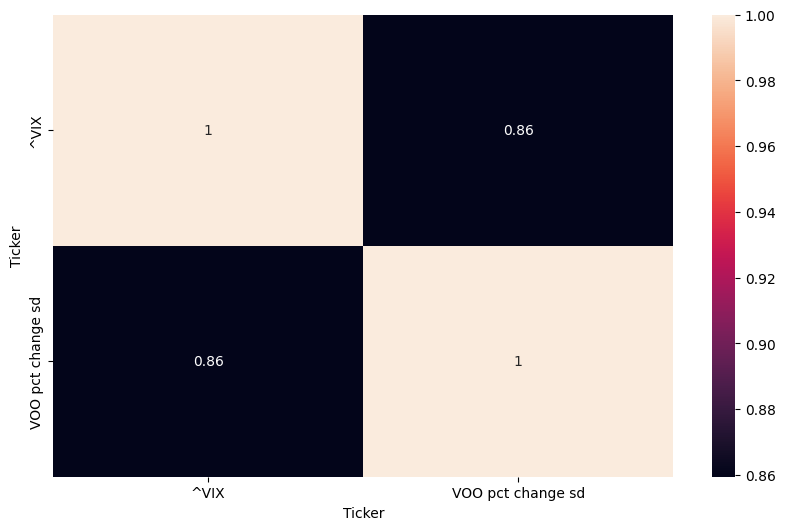

In [9]:
#Plot correlation matrix for all variables
df_corr_1 = df[['^VIX','VOO pct change sd']]
plt.figure(figsize=(10,6))
c = df_corr_1.corr()
sns.heatmap(c, annot=True)
plt.show()

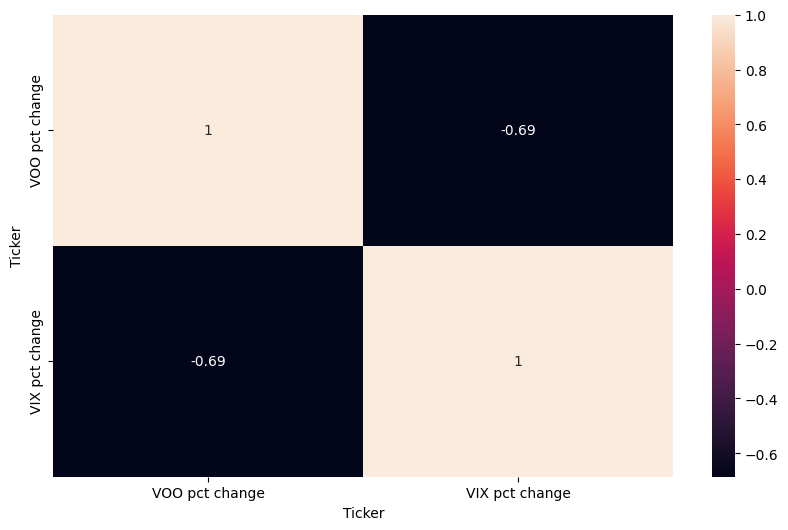

In [10]:
#Plot correlation matrix for all variables
df_corr_2 = df[['VOO pct change','VIX pct change']]
plt.figure(figsize=(10,6))
c = df_corr_2.corr()
sns.heatmap(c, annot=True)
plt.show()

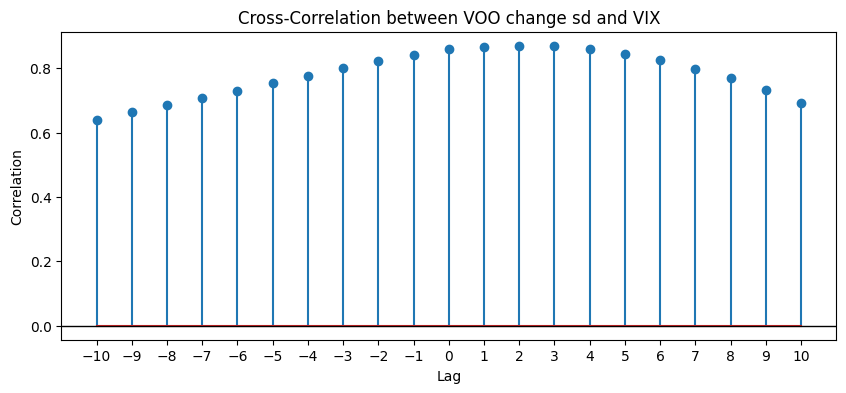

In [11]:
max_lag = 10

# Calculate cross-correlation
lags = np.arange(-10, 11)
cross_corrs = [df['VOO pct change sd'].corr(df['^VIX'].shift(lag)) for lag in lags]

# Plot cross-correlation
plt.figure(figsize=(10, 4))
plt.stem(lags, cross_corrs)
plt.axhline(0, color='black', lw=1)
plt.xticks(np.arange(-max_lag, max_lag + 1, 1))
plt.title('Cross-Correlation between VOO change sd and VIX')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

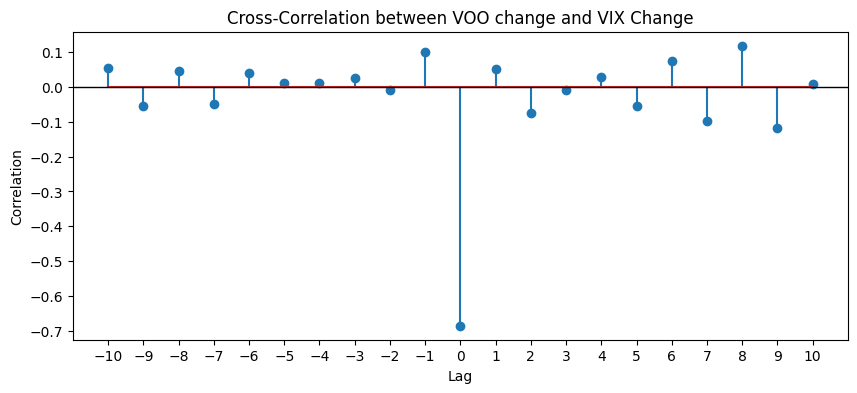

In [12]:
max_lag = 10

# Calculate cross-correlation
lags = np.arange(-10, 11)
cross_corrs = [df['VOO pct change'].corr(df['VIX pct change'].shift(lag)) for lag in lags]

# Plot cross-correlation
plt.figure(figsize=(10, 4))
plt.stem(lags, cross_corrs)
plt.axhline(0, color='black', lw=1)
plt.xticks(np.arange(-max_lag, max_lag + 1, 1))
plt.title('Cross-Correlation between VOO change and VIX Change')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

# Feature Engineering

In [14]:
df['VIX lag 1']    = df['^VIX'].shift(1)
df['VIX SMA 20']   = df['^VIX'].rolling(20).mean()

# RSI

In [13]:
df ['VOO RSI 7']        = RSIIndicator(close = df['VOO'], window =7).rsi()
df ['VIX RSI 7']        = RSIIndicator(close = df['^VIX'], window =7).rsi()
df ['VOO RSI 14']       = RSIIndicator(close = df['VOO'], window =14).rsi()
df ['VIX RSI 14']       = RSIIndicator(close = df['^VIX'], window =14).rsi()
df ['VOO RSI 35']       = RSIIndicator(close = df['VOO'], window =35).rsi()
df ['VIX RSI 35']       = RSIIndicator(close = df['^VIX'], window =35).rsi()
df ['VOO RSI 7 - 35']   = df ['VOO RSI 7'] - df ['VOO RSI 35']
df ['VIX RSI 7 - 35']   = df ['VIX RSI 7'] - df ['VIX RSI 35']
print(df.tail())

Ticker             VOO       ^VIX  VOO pct change  VIX pct change  \
Date                                                                
2024-12-23  545.299500  16.780001        0.007158       -0.086057   
2024-12-24  550.910034  14.270000        0.010289       -0.149583   
2024-12-26  550.900024  14.730000       -0.000018        0.032235   
2024-12-27  545.189880  15.950000       -0.010365        0.082824   
2024-12-30  539.120850  17.400000       -0.011132        0.090909   

Ticker      VOO pct change sd  VIX pct change sd  VOO RSI 7  VIX RSI 7  \
Date                                                                     
2024-12-23           0.179624           4.183088  48.212106  48.004963   
2024-12-24           0.188160           4.289736  58.206916  41.527955   
2024-12-26           0.183527           4.272885  58.183543  43.167470   
2024-12-27           0.188894           4.279617  45.913442  47.704590   
2024-12-30           0.195150           4.278022  36.395993  52.916607  

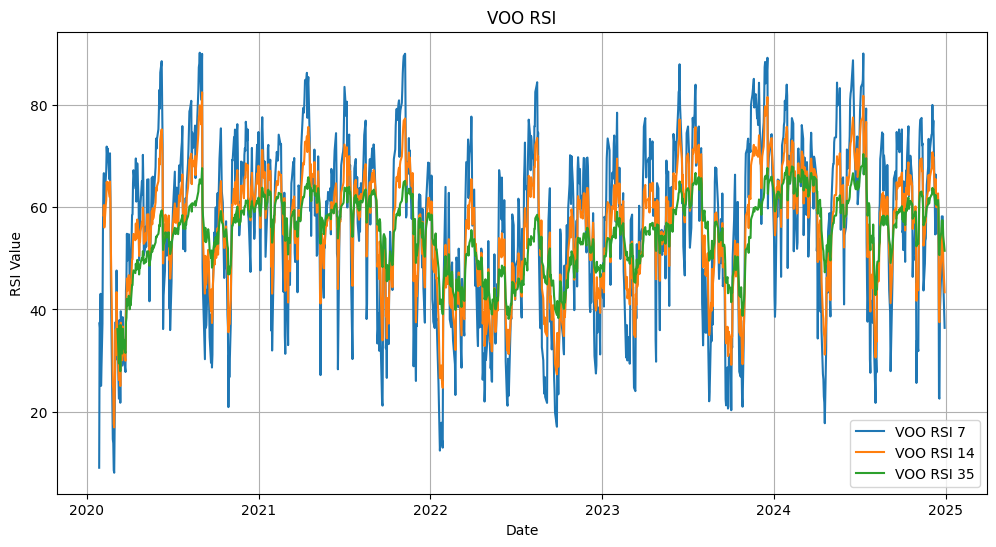

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['VOO RSI 7'], label='VOO RSI 7')
plt.plot(df.index, df['VOO RSI 14'], label='VOO RSI 14')
plt.plot(df.index, df['VOO RSI 35'], label='VOO RSI 35')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.title('VOO RSI')
plt.legend()
plt.grid(True)
plt.show()


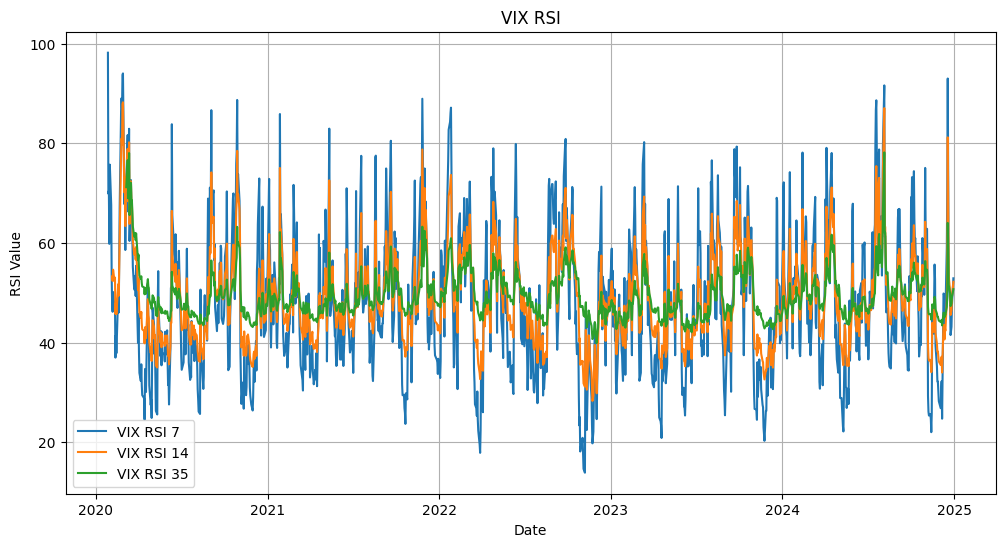

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['VIX RSI 7'], label='VIX RSI 7')
plt.plot(df.index, df['VIX RSI 14'], label='VIX RSI 14')
plt.plot(df.index, df['VIX RSI 35'], label='VIX RSI 35')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.title('VIX RSI')
plt.legend()
plt.grid(True)
plt.show()


# Trading Strategy based on VIX level

In [16]:
def backtest_1(df):
  df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

  # Loop through the data to generate signals
  # Use df.index to access rows by their actual index values (dates)
  for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
      if df.loc[i,'^VIX'] > 30 : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = 1
      elif df.loc[i,'^VIX'] < 10 : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = -1
      else:
          df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

  # Calculate daily returns based on the strategy
  df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
  df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

  # Calculate cumulative returns for the strategy and the benchmark
  df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
  df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

  # Plot cumulative returns
  plt.figure(figsize=(12, 6))
  plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
  plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Returns')
  plt.title('Backtest Results')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Evaluate Performance (example metrics)
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
  print(f"Total Strategy Return: {strategy_total_return:.2f}%")
  print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

  #Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

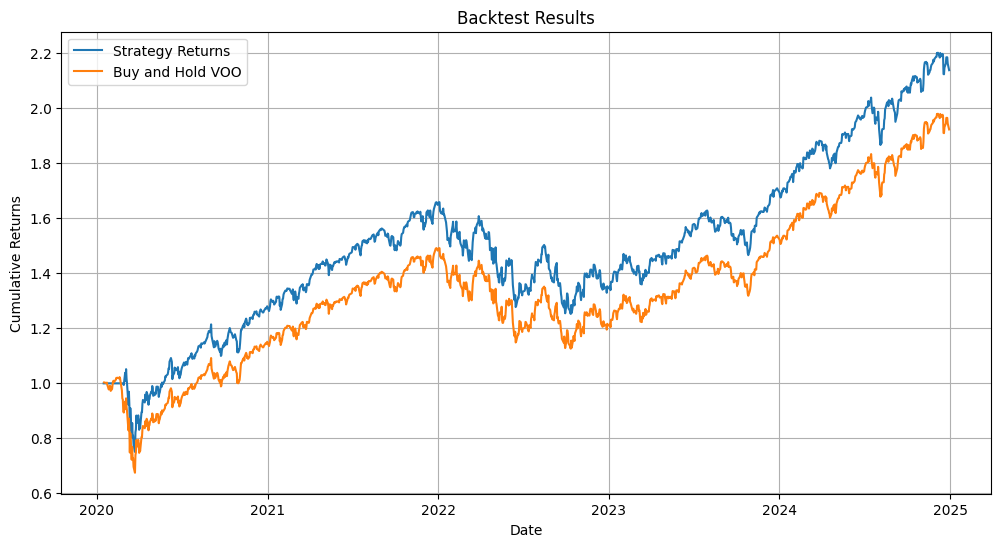

Total Strategy Return: 113.87%
Total Buy and Hold VOO Return: 92.31%


<ipython-input-16-61ac0efa4877>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-16-61ac0efa4877>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [17]:
backtest_1(df)

# Trading Strategy based on VIX RSI

In [22]:
def backtest_2(df):
  df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

  # Loop through the data to generate signals
  # Use df.index to access rows by their actual index values (dates)
  for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
      if df.loc[i,'^VIX'] > 30 and df.loc[i,'VIX RSI 14'] > 70 : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = 1
      elif df.loc[i,'^VIX'] < 10 and df.loc[i,'VIX RSI 14']  < 30: # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = -1
      else:
          df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

  # Calculate daily returns based on the strategy
  df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
  df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

  # Calculate cumulative returns for the strategy and the benchmark
  df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
  df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

  # Plot cumulative returns
  plt.figure(figsize=(12, 6))
  plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
  plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Returns')
  plt.title('Backtest Results')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Evaluate Performance (example metrics)
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
  print(f"Total Strategy Return: {strategy_total_return:.2f}%")
  print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

  #Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

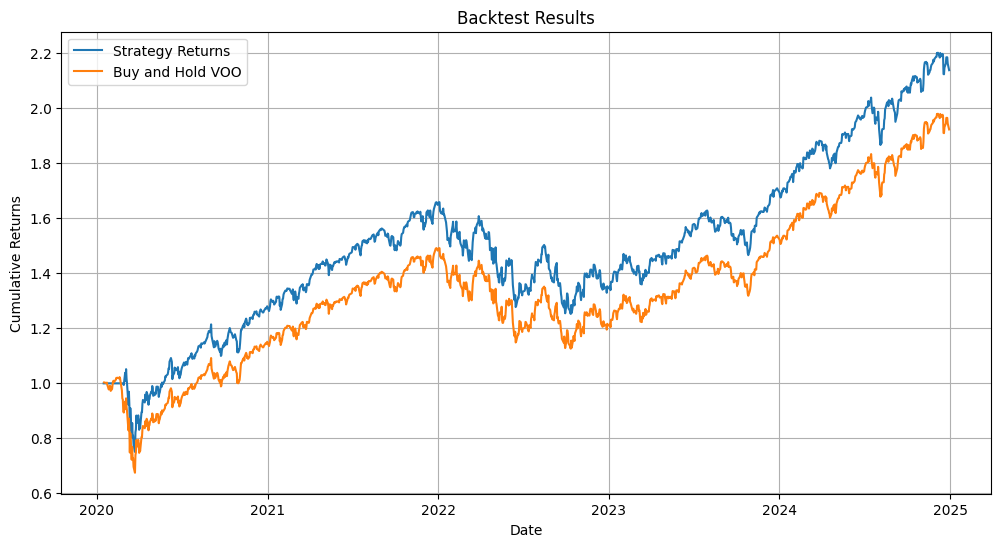

Total Strategy Return: 113.87%
Total Buy and Hold VOO Return: 92.31%


<ipython-input-22-cff175fd14a2>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-22-cff175fd14a2>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [23]:
backtest_2(df)